# tf.data API로 성능 향상하기

* https://www.tensorflow.org/guide/data_performance?hl=ko

In [1]:
import tensorflow as tf
import time

## 재현 가능한 Benchmark 준비

* 파일에서 느리게 읽는 것을 묘사하는 Dataset
* 비효율 = 파일 읽는 동안 훈련이 놀고, 훈련하는 동안 파일 읽기가 논다.

In [2]:
class ArtificialDataset(tf.data.Dataset):
    def _generator(num_samples):
        # 파일 열기
        time.sleep(0.03)

        for sample_idx in range(num_samples):
            # 파일에서 데이터(줄, 기록) 읽기
            time.sleep(0.015)

            yield (sample_idx,)

    def __new__(cls, num_samples=3):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_types=tf.dtypes.int64,
            output_shapes=(1,),
            args=(num_samples,)
        )
    
def benchmark(dataset, num_epochs=2):
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        for sample in dataset:
            # 훈련 스텝마다 실행
            time.sleep(0.01)
    tf.print("실행 시간:", time.perf_counter() - start_time)    

In [3]:
benchmark(ArtificialDataset())

실행 시간: 0.24353023299772758


## Prefetch를 통한 성능 향상

* 가져오기는 전처리와 훈련 스텝의 모델 실행을 오버랩합니다. 모델이 s스텝 훈련을 실행하는 동안 입력 파이프라인은 s+1스텝의 데이터를 읽습니다. 이렇게 하면 훈련을 하는 최대(합과 반대로) 스텝 시간과 데이터를 추출하는 데 걸리는 시간을 단축시킬 수 있습니다

In [4]:
benchmark(
    ArtificialDataset()
    .prefetch(tf.data.experimental.AUTOTUNE)
)

실행 시간: 0.18665794199841912


## 순차적 인터리브

* 여러 데이터셋에서 인터리빙하여 병렬화 => 해당 예제에서는 안됨

In [5]:
benchmark(
    tf.data.Dataset.range(2)
    .interleave(ArtificialDataset)
)

실행 시간: 0.2186432419985067


## 병렬 인터리브

In [6]:
 benchmark(
     tf.data.Dataset.range(2)
     .interleave(
         ArtificialDataset,
         num_parallel_calls=tf.data.experimental.AUTOTUNE
     )
 )

실행 시간: 0.1307047530026466


## 데이터 변환 병렬화

In [7]:
def mapped_function(s):
    # Do some hard pre-processing
    tf.py_function(lambda: time.sleep(0.03), [], ())
    return s

### 순차적 매핑 => 느려짐

In [8]:
benchmark(
    ArtificialDataset()
    .map(mapped_function)
)

실행 시간: 0.4175068140029907


### 병렬 매핑

In [10]:
benchmark(
    ArtificialDataset()
    .map(mapped_function,
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
)

실행 시간: 0.2743188439999358


## 캐시하기

* 각 epoch별로 또다시 하지 않게 하기

In [18]:
benchmark(
    ArtificialDataset()
    .map(
        mapped_function
    ).cache(
    ),
    6
)

실행 시간: 0.4607433769997442


## 배치

* 단건씩 처리하는 것은 overhead 야기 => miniBatch가 크면 클수록 유리
* map.batch 가 아닌 batch.map을 하자

In [19]:
fast_dataset = tf.data.Dataset.range(10000)

def fast_benchmark(dataset, num_epochs=2):
    start_time = time.perf_counter()
    for _ in tf.data.Dataset.range(num_epochs):
        for _ in dataset:
            pass
    tf.print("실행 시간:", time.perf_counter() - start_time)

def increment(x):
    return x+1

In [20]:
fast_benchmark(
    fast_dataset
    # 한 번에 한 항목씩 함수 적용
    .map(increment)
    # 배치
    .batch(256)
)

실행 시간: 0.24494167900047614


In [21]:
fast_benchmark(
    fast_dataset
    .batch(256)
    # items의 배치에 함수 적용
    # tf.Tensor.__add__ 메서드는 이미 배치를 다룸
    .map(increment)
)

실행 시간: 0.017439276998629794


## 메모리 사용량(footprint) 줄이기

* interleave, prefetch, shuffle => 많은 메모리 요구
* 변환 중에 메모리 요구사항이 많은 것은 cache 뒤로 보내기
  * dataset.map(time_consuming_mapping).cache().map(memory_consuming_mapping)

# 가장 좋은 예제

In [23]:
import itertools
from collections import defaultdict
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

class TimeMeasuredDataset(tf.data.Dataset):
    # 출력: (steps, timings, counters)
    OUTPUT_TYPES = (tf.dtypes.string, tf.dtypes.float32, tf.dtypes.int32)
    OUTPUT_SHAPES = ((2, 1), (2, 2), (2, 3))

    _INSTANCES_COUNTER = itertools.count()  # 생성된 데이터셋 수
    _EPOCHS_COUNTER = defaultdict(itertools.count)  # 각 데이터를 수행한 에포크 수

    def _generator(instance_idx, num_samples):
        epoch_idx = next(TimeMeasuredDataset._EPOCHS_COUNTER[instance_idx])

        # 파일 열기
        open_enter = time.perf_counter()
        time.sleep(0.03)
        open_elapsed = time.perf_counter() - open_enter

        for sample_idx in range(num_samples):
            # 파일에서 데이터(줄, 기록) 읽어오기
            read_enter = time.perf_counter()
            time.sleep(0.015)
            read_elapsed = time.perf_counter() - read_enter

            yield (
                [("Open",), ("Read",)],
                [(open_enter, open_elapsed), (read_enter, read_elapsed)],
                [(instance_idx, epoch_idx, -1), (instance_idx, epoch_idx, sample_idx)]
            )
            open_enter, open_elapsed = -1., -1.  # 음수는 필터링됨


    def __new__(cls, num_samples=3):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_types=cls.OUTPUT_TYPES,
            output_shapes=cls.OUTPUT_SHAPES,
            args=(next(cls._INSTANCES_COUNTER), num_samples)
        )
    
def timelined_benchmark(dataset, num_epochs=2):
    # 누산기 초기화
    steps_acc = tf.zeros([0, 1], dtype=tf.dtypes.string)
    times_acc = tf.zeros([0, 2], dtype=tf.dtypes.float32)
    values_acc = tf.zeros([0, 3], dtype=tf.dtypes.int32)

    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        epoch_enter = time.perf_counter()
        for (steps, times, values) in dataset:
            # 데이터셋 준비 정보 기록하기
            steps_acc = tf.concat((steps_acc, steps), axis=0)
            times_acc = tf.concat((times_acc, times), axis=0)
            values_acc = tf.concat((values_acc, values), axis=0)

            # 훈련 시간 시뮬레이션
            train_enter = time.perf_counter()
            time.sleep(0.01)
            train_elapsed = time.perf_counter() - train_enter

            # 훈련 정보 기록하기
            steps_acc = tf.concat((steps_acc, [["Train"]]), axis=0)
            times_acc = tf.concat((times_acc, [(train_enter, train_elapsed)]), axis=0)
            values_acc = tf.concat((values_acc, [values[-1]]), axis=0)

        epoch_elapsed = time.perf_counter() - epoch_enter
        # 에포크 정보 기록하기
        steps_acc = tf.concat((steps_acc, [["Epoch"]]), axis=0)
        times_acc = tf.concat((times_acc, [(epoch_enter, epoch_elapsed)]), axis=0)
        values_acc = tf.concat((values_acc, [[-1, epoch_num, -1]]), axis=0)
        time.sleep(0.001)

    tf.print("실행 시간:", time.perf_counter() - start_time)
    return {"steps": steps_acc, "times": times_acc, "values": values_acc}    

def draw_timeline(timeline, title, width=0.5, annotate=False, save=False):
    # 타임라인에서 유효하지 않은 항목(음수 또는 빈 스텝) 제거
    invalid_mask = np.logical_and(timeline['times'] > 0, timeline['steps'] != b'')[:,0]
    steps = timeline['steps'][invalid_mask].numpy()
    times = timeline['times'][invalid_mask].numpy()
    values = timeline['values'][invalid_mask].numpy()

    # 처음 발견될 때 순서대로 다른 스텝을 가져옵니다.
    step_ids, indices = np.stack(np.unique(steps, return_index=True))
    step_ids = step_ids[np.argsort(indices)]

    # 시작 시간을 0으로 하고 최대 시간 값을 계산하십시오.
    min_time = times[:,0].min()
    times[:,0] = (times[:,0] - min_time)
    end = max(width, (times[:,0]+times[:,1]).max() + 0.01)

    cmap = mpl.cm.get_cmap("plasma")
    plt.close()
    fig, axs = plt.subplots(len(step_ids), sharex=True, gridspec_kw={'hspace': 0})
    fig.suptitle(title)
    fig.set_size_inches(17.0, len(step_ids))
    plt.xlim(-0.01, end)

    for i, step in enumerate(step_ids):
        step_name = step.decode()
        ax = axs[i]
        ax.set_ylabel(step_name)
        ax.set_ylim(0, 1)
        ax.set_yticks([])
        ax.set_xlabel("time (s)")
        ax.set_xticklabels([])
        ax.grid(which="both", axis="x", color="k", linestyle=":")

        # 주어진 단계에 대한 타이밍과 주석 얻기
        entries_mask = np.squeeze(steps==step)
        serie = np.unique(times[entries_mask], axis=0)
        annotations = values[entries_mask]

        ax.broken_barh(serie, (0, 1), color=cmap(i / len(step_ids)), linewidth=1, alpha=0.66)
        if annotate:
            for j, (start, width) in enumerate(serie):
                annotation = "\n".join([f"{l}: {v}" for l,v in zip(("i", "e", "s"), annotations[j])])
                ax.text(start + 0.001 + (0.001 * (j % 2)), 0.55 - (0.1 * (j % 2)), annotation,
                        horizontalalignment='left', verticalalignment='center')
    if save:
        plt.savefig(title.lower().translate(str.maketrans(" ", "_")) + ".svg")
        
def map_decorator(func):
    def wrapper(steps, times, values):
        # 자동 그래프가 메서드를 컴파일하지 못하도록 tf.py_function을 사용
        return tf.py_function(
            func,
            inp=(steps, times, values),
            Tout=(steps.dtype, times.dtype, values.dtype)
        )
    return wrapper        

_batch_map_num_items = 50

def dataset_generator_fun(*args):
    return TimeMeasuredDataset(num_samples=_batch_map_num_items)

## Naive 

In [24]:
@map_decorator
def naive_map(steps, times, values):
    map_enter = time.perf_counter()
    time.sleep(0.001)  # 시간 소비 스텝
    time.sleep(0.0001)  # 메모리 소비 스텝
    map_elapsed = time.perf_counter() - map_enter

    return (
        tf.concat((steps, [["Map"]]), axis=0),
        tf.concat((times, [[map_enter, map_elapsed]]), axis=0),
        tf.concat((values, [values[-1]]), axis=0)
    )

naive_timeline = timelined_benchmark(
    tf.data.Dataset.range(2)
    .flat_map(dataset_generator_fun)
    .map(naive_map)
    .batch(_batch_map_num_items, drop_remainder=True)
    .unbatch(),
    5
)

실행 시간: 12.986734456000704


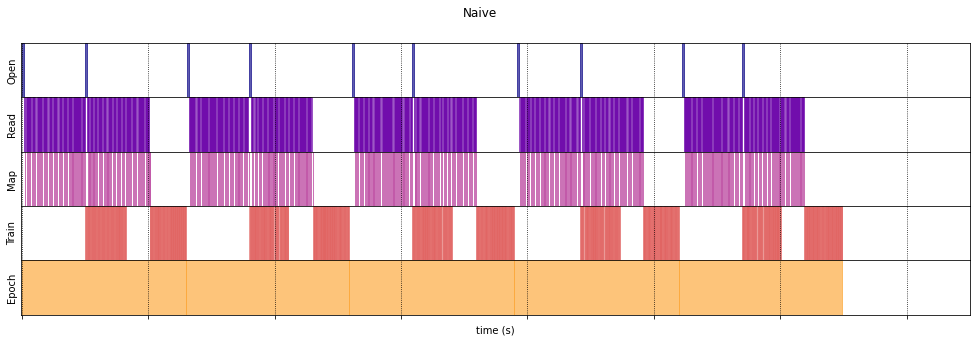

In [26]:
draw_timeline(naive_timeline, "Naive", 15)

## Optimized

In [25]:
@map_decorator
def time_consumming_map(steps, times, values):
    map_enter = time.perf_counter()
    time.sleep(0.001 * values.shape[0])  # 시간 소비 스텝
    map_elapsed = time.perf_counter() - map_enter

    return (
        tf.concat((steps, tf.tile([[["1st map"]]], [steps.shape[0], 1, 1])), axis=1),
        tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [times.shape[0], 1, 1])), axis=1),
        tf.concat((values, tf.tile([[values[:][-1][0]]], [values.shape[0], 1, 1])), axis=1)
    )


@map_decorator
def memory_consumming_map(steps, times, values):
    map_enter = time.perf_counter()
    time.sleep(0.0001 * values.shape[0])  # 메모리 소비 스텝
    map_elapsed = time.perf_counter() - map_enter

    # 배치 차원을 다루는 데 tf.tile 사용
    return (
        tf.concat((steps, tf.tile([[["2nd map"]]], [steps.shape[0], 1, 1])), axis=1),
        tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [times.shape[0], 1, 1])), axis=1),
        tf.concat((values, tf.tile([[values[:][-1][0]]], [values.shape[0], 1, 1])), axis=1)
    )


optimized_timeline = timelined_benchmark(
    tf.data.Dataset.range(2)
    .interleave(  # 데이터 읽기 병렬화
        dataset_generator_fun,
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(  # 매핑된 함수 벡터화
        _batch_map_num_items,
        drop_remainder=True)
    .map(  # 맵 변환 병렬화
        time_consumming_map,
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .cache()  # 데이터 캐시
    .map(  # 메모리 사용량 줄이기
        memory_consumming_map,
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .prefetch(  # 프로듀서와 컨슈머 작업 오버랩
        tf.data.experimental.AUTOTUNE
    )
    .unbatch(),
    5
)

실행 시간: 6.625343454998074


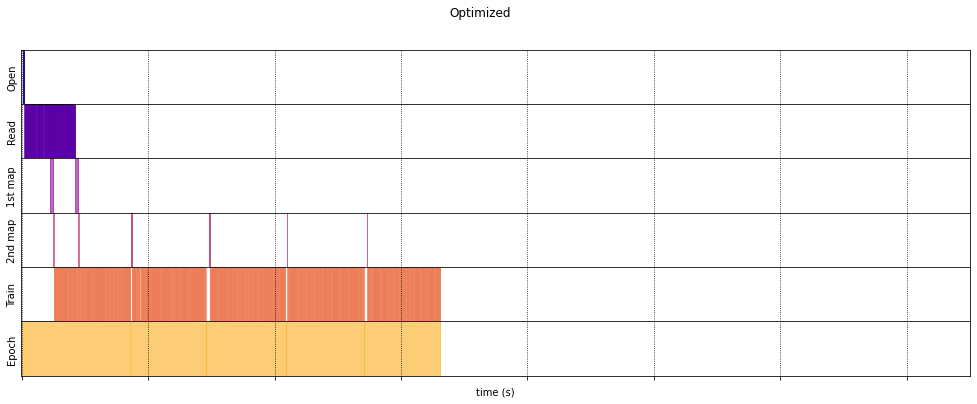

In [27]:
draw_timeline(optimized_timeline, "Optimized", 15)